# 1. Python performance

<br><br><br><br><br>

## Python is now mainstream

Below is an analysis of GitHub repos created by CMS physicists (i.e. "everyone who forked cms-sw/cmssw").

GitHub labels these repos as C/C++, Python, or Jupyter: the Python and Jupyter categories are now the most common.

<img src="img/lhlhc-github-languages.svg" style="width: 800px">

Furthermore, if we search for strings inside these repos, words like "`numpy`" are found in more repos than words like "`TFile`" (proxy for ROOT).

`"uproot"` is also fairly common, but not as much as the likes of NumPy and ROOT.

<img src="img/lhlhc-github-overlay-lin.svg" style="width: 800px">

We also asked questions about this at last year's PyHEP workshop (408 respondents, about 90 in CMS).

You use Python about equally with C++, and primarily for analysis (not just machine learning).

<img src="img/pyhep2020-survey-5.svg" style="width: 80%">

<br><br><br><br><br>

## General facts about Python

   1. Python is fun and easy.
   2. Python is slow.

But if you're working with large datasets, you need it to be fast.

What can you do?

<br><br><br><br><br>

<div style="font-size: 25px; margin-bottom: 30px;">
    Try this one weird trick!
</div>

<div style="font-size: 25px; border: 1px dashed black; padding: 15px; margin-bottom: 30px;">
    <div><b>Step 1:</b> isolate the "number crunching" part of your task</div>
    <div><b>Step 2:</b> offload that part to compiled code</div>
</div>

This will be the core message of our overview of Uproot and Awkward Array.

<br><br><br><br><br>

## Way-too-simple example

Let's say that you have a lot of $p_x$ and $p_y$ values and you want to compute $p_T$.

In [1]:
import random
import math

px = [random.gauss(0, 10) for i in range(100000)]
py = [random.gauss(0, 10) for i in range(100000)]

The pure Python way to do this is with a loop:

In [2]:
%%timeit

pt = []
for px_i, py_i in zip(px, py):
    pt.append(math.sqrt(px_i**2 + py_i**2))

49.2 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


But Python is slow: each step in the for loop performs type-checking, boxing/unboxing number classes, chasing references, etc.

Putting it in a list comprehension doesn't help (much), because that's still a Python for loop.

In [3]:
%%timeit

pt = [math.sqrt(px_i**2 + py_i**2) for px_i, py_i in zip(px, py)]

48.6 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's why we use NumPy.

In [4]:
import numpy as np

px = np.array(px)
py = np.array(py)
px, py

(array([-7.5405665 , -4.27711683, -6.06357233, ..., 14.89027678,
        18.30280526,  6.24375645]),
 array([ 7.19813126, -4.14890871, -3.73416621, ...,  2.18793438,
        -9.31413026,  7.23904115]))

In [5]:
%%timeit

pt = np.sqrt(px**2 + py**2)

395 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


But notice that just "using NumPy" isn't what makes it faster: it's the fact that all the data were handled in few Python function calls.

Calling NumPy on individual items in a loop doesn't help. (In fact, it's worse than iteration over builtin Python lists.)

In [6]:
%%timeit

pt = [np.sqrt(px_i**2 + py_i**2) for px_i, py_i in zip(px, py)]

274 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Rough way to estimate performance of small datasets: count the number of Python steps.

<br><br><br>

Unfortunately, some problems (not this one) are more easily expressed one item at a time (e.g. one event at a time).

You can still write iterative loops if they are in compiled code.

ROOT can compile C++ functions and make them accessible in Python with PyROOT and RDataFrame (example in the next notebook).

In [7]:
import ROOT

Welcome to JupyROOT 6.22/08


In [8]:
ROOT.gInterpreter.Declare('''
void compute_pt(int32_t N, double* px, double* py, double* pt) {
    for (int32_t i = 0; i < N; i++) {
        pt[i] = sqrt(px[i]*px[i] + py[i]* py[i]);
    }
}
''')

True

In [9]:
pt = np.empty_like(px)
ROOT.compute_pt(len(px), px, py, pt)
pt

array([10.42464564,  5.95878946,  7.12115908, ..., 15.05016277,
       20.53644815,  9.55971817])

In [10]:
%%timeit

ROOT.compute_pt(len(px), px, py, pt)

656 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


ROOT is just-in-time (JIT) compiling the C++ code.

You can also JIT-compile a subset of _Python_ code using Numba.

In [11]:
import numba as nb

@nb.jit
def compute_pt(px, py):
    pt = np.empty_like(px)
    for i, (px_i, py_i) in enumerate(zip(px, py)):
        pt[i] = np.sqrt(px_i**2 + py_i**2)
    return pt

In [12]:
compute_pt(px, py)

array([10.42464564,  5.95878946,  7.12115908, ..., 15.05016277,
       20.53644815,  9.55971817])

In [13]:
%%timeit

compute_pt(px, py)

299 µs ± 3.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


For a tutorial on Numba, [watch this](https://youtu.be/X_BJrmofRWQ).

<br><br><br><br><br>

## Not-too-simple example

Let's do a more interesting calculation: reproduce this cellular automata ([source](http://www.ericweisstein.com/encyclopedias/life/Puffer.html)):

<img src="img/game-of-life-puffer.gif" style="width: 813px">

It works by applying the following rules to a 2-dimensional grid of boolean-valued cells:

   * If the cell is filled and is surrounded by more than 1 and fewer than 4 filled cells, it will remain filled.
   * If the cell is empty and is surrounded by 3 filled cells, it will become filled.
   * Otherwise, the cell is or becomes empty.

For the self-propelling "puffer" pattern, the grid must be initially filled like this:

In [14]:
WIDTH = 128
HEIGHT = 32

def new_world():
    world = [[0 for i in range(WIDTH)] for j in range(HEIGHT)]

    for x, y in [
        ( 4, 125), ( 3, 124), ( 3, 123), ( 3, 122), ( 3, 121), ( 3, 120), ( 3, 119), ( 4, 119), ( 5, 119), ( 6, 120),
        (10, 121), (11, 120), (12, 119), (12, 120), (13, 120), (13, 121), (14, 121),
        (20, 121), (19, 120), (18, 120), (18, 119), (17, 121), (17, 120), (16, 121),
        (26, 125), (27, 124), (27, 123), (27, 122), (27, 121), (27, 120), (27, 119), (26, 119), (25, 119), (24, 120)
    ]:
        world[x][y] = 1

    return world

world = new_world()

In [15]:
def show(world):
    for row in world:
        stars = "".join("*" if cell else " " for cell in row)
        print("|" + stars + "|")

show(world)

|                                                                                                                                |
|                                                                                                                                |
|                                                                                                                                |
|                                                                                                                       ******   |
|                                                                                                                       *     *  |
|                                                                                                                       *        |
|                                                                                                                        *       |
|                                                                                  

<br><br><br><br><br>

### Try it in Python!

In [16]:
def step_python(world):
    outworld = []
    for i, row in enumerate(world):
        outrow = []
        for j, cell in enumerate(row):
            # count the number of living neighbors
            num_neighbors = 0
            for di in -1, 0, 1:
                for dj in -1, 0, 1:
                    if (di, dj) != (0, 0):
                        if world[(i + di) % HEIGHT][(j + dj) % WIDTH]:
                            num_neighbors += 1

            # use that information to decide if the next value of this cell is 0 or 1
            if cell and 1 < num_neighbors < 4:
                outrow.append(1)
            elif not cell and num_neighbors == 3:
                outrow.append(1)
            else:
                outrow.append(0)

        outworld.append(outrow)
    return outworld

Repeatedly evaluate the next cell to animate it.

In [44]:
world = step_python(world)
show(world)

|                                                                                                                                |
|                                                                                                                                |
|                                                                                                                                |
|                                                                                                         ******                 |
|                                                                                                         *     *                |
|                                                                                                         *                      |
|                                                                                                          *    *                |
|                                                                                  

But the Python implementation is slow.

In [45]:
%%timeit

step_python(world)

10.3 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br><br><br><br><br>

### Try it in C!

In [46]:
%%writefile game-of-life.c

#include <stdint.h>

const int32_t WIDTH = 128;
const int32_t HEIGHT = 32;

void step_c(int8_t* inarray, int8_t* outarray) {
    for (int32_t i = 0; i < HEIGHT; i++) {
        for (int32_t j = 0; j < WIDTH; j++) {
            // count the number of living neighbors
            int32_t num_neighbors = 0;
            for (int32_t di = -1; di <= 1; di++) {
                for (int32_t dj = -1; dj <= 1; dj++) {
                    if (!(di == 0 && dj == 0)) {
                        if (inarray[((i + di + HEIGHT) % HEIGHT) * WIDTH + ((j + dj + WIDTH) % WIDTH)]) {
                            num_neighbors++;
                        }
                    }
                }
            }

            // use that information to decide if the next value of this cell is 0 or 1
            int8_t cell = inarray[i * WIDTH + j];
            if (cell && 1 < num_neighbors && num_neighbors < 4) {
                outarray[i * WIDTH + j] = 1;
            }
            else if (!cell && num_neighbors == 3) {
                outarray[i * WIDTH + j] = 1;
            }
            else {
                outarray[i * WIDTH + j] = 0;
            }
        }
    }

    // copy the outarray buffer to the inarray buffer (so the above can be repeated)
    for (int32_t i = 0; i < HEIGHT; i++) {
        for (int32_t j = 0; j < WIDTH; j++) {
            inarray[i * WIDTH + j] = outarray[i * WIDTH + j];
        }
    }
}

Overwriting game-of-life.c


In [47]:
!gcc -std=c99 game-of-life.c -O3 -shared -o game-of-life.so

Here's a different way to access C code (not C++, or use `extern C`) in Python: ctypes.

In [48]:
import ctypes

ArrayType = ctypes.c_int8 * WIDTH * HEIGHT

step_c = ctypes.cdll.LoadLibrary("./game-of-life.so").step_c
step_c.argtypes = [ArrayType, ArrayType]
step_c.restype = None

In [49]:
inarray = ArrayType()
outarray = ArrayType()

for i, row in enumerate(new_world()):
    for j, cell in enumerate(row):
        inarray[i][j] = cell

In [81]:
step_c(inarray, outarray, 1)
show(outarray)

|                                                                                                                                |
|                                                                                                                                |
|                                                                                                                                |
|                                                                                                       ******                   |
|                                                                                                       *     *                  |
|                                                                                                       *                        |
|                                                                                                        *    *                  |
|                                                                                  

The C code is much faster.

In [82]:
%%timeit

step_c(inarray, outarray)

27.7 µs ± 807 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<br><br><br><br><br>

### Try it in NumPy!

The NumPy implementation is tricky because we have to mix data from different cells.

   * [np.roll](https://numpy.org/doc/stable/reference/generated/numpy.roll.html) rotates an array, which we use to add up the neighbors an array at a time.
   * `&` and `|` perform bitwise logic, but be careful! Comparisons like `<`, `==`, `>` have to be parenthesized because of [order of operations](https://docs.python.org/3/reference/expressions.html#operator-precedence).

In [83]:
import numpy as np

def step_numpy(world):
    num_neighbors = np.zeros(world.shape, dtype=int)                        # initialize neighbors count
    num_neighbors += np.roll(np.roll(world,  1, axis=0),  1, axis=1)        # add southwest
    num_neighbors += np.roll(np.roll(world,  1, axis=0),  0, axis=1)        # add south
    num_neighbors += np.roll(np.roll(world,  1, axis=0), -1, axis=1)        # add southeast
    num_neighbors += np.roll(np.roll(world,  0, axis=0),  1, axis=1)        # add west
    num_neighbors += np.roll(np.roll(world,  0, axis=0), -1, axis=1)        # add east
    num_neighbors += np.roll(np.roll(world, -1, axis=0),  1, axis=1)        # add northwest
    num_neighbors += np.roll(np.roll(world, -1, axis=0),  0, axis=1)        # add north
    num_neighbors += np.roll(np.roll(world, -1, axis=0), -1, axis=1)        # add northeast

    survivors = ((world == 1) & (num_neighbors > 1) & (num_neighbors < 4))  # old cells that survive
    births    = ((world == 0) & (num_neighbors == 3))                       # new cells that are born

    return (births | survivors).astype(world.dtype)                         # union as booleans

world = np.array(new_world())

In [107]:
world = step_numpy(world)
show(world)

|                                                                                                                                |
|                                                                                                                                |
|                                                                                                                                |
|                                                                                                           ******               |
|                                                                                                           *     *              |
|                                                                                                           *                    |
|                                                                                                            *    *    **        |
|                                                                                  

NumPy is _between_ the pure Python and the C code because the C code scans the data in a single pass.

NumPy makes many passes over the data (creating temporary arrays) in each `np.roll`.

In [108]:
%%timeit

step_numpy(world)

432 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<br><br><br><br><br>

### Try it in SciPy!

The many-passes problem can be reduced by finding a function that computes what we want in a single pass.

SciPy has one: counting neighbors is a special case of convolution: [scipy.signal.convolve2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html).

In [109]:
import scipy.signal

num_neighbors_convolver = np.array([[1, 1, 1],
                                    [1, 0, 1],
                                    [1, 1, 1]])

def step_scipy(world):
    # this is the step that can now be one function call:
    num_neighbors = scipy.signal.convolve2d(world, num_neighbors_convolver, mode="same", boundary="wrap")
    
    survivors = ((world == 1) & (num_neighbors > 1) & (num_neighbors < 4))  # old cells that survive
    births    = ((world == 0) & (num_neighbors == 3))                       # new cells that are born

    return (births | survivors).astype(world.dtype)                         # union as booleans

world = np.array(new_world())

In [110]:
world = step_scipy(world)
show(world)

|                                                                                                                                |
|                                                                                                                                |
|                                                                                                                        ****    |
|                                                                                                                       ******   |
|                                                                                                                      ** ****   |
|                                                                                                                       **       |
|                                                                                                                                |
|                                                                                  

This version performs fewer passes and is a little better.

In [111]:
%%timeit

step_scipy(world)

266 µs ± 14.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<br><br><br><br><br>

### Try it in Numba!

JIT-compilation is the ultimate solution to the many-pass problem. Numba lets us write code that looks like our pure Python function.

In [112]:
import numba as nb

@nb.jit
def step_numba(world):
    outworld = np.empty_like(world)
    for i, row in enumerate(world):
        for j, cell in enumerate(row):
            # count the number of living neighbors
            num_neighbors = 0
            for di in -1, 0, 1:
                for dj in -1, 0, 1:
                    if (di, dj) != (0, 0):
                        if world[(i + di) % HEIGHT][(j + dj) % WIDTH]:
                            num_neighbors += 1

            # use that information to decide if the next value of this cell is 0 or 1
            if cell and 1 < num_neighbors < 4:
                outworld[i, j] = 1
            elif not cell and num_neighbors == 3:
                outworld[i, j] = 1
            else:
                outworld[i, j] = 0

    return outworld

world = np.array(new_world())

In [113]:
world = step_numba(world)
show(world)

|                                                                                                                                |
|                                                                                                                                |
|                                                                                                                        ****    |
|                                                                                                                       ******   |
|                                                                                                                      ** ****   |
|                                                                                                                       **       |
|                                                                                                                                |
|                                                                                  

It's _almost_ as fast as C code, but easier to integrate into a Python session.

In [114]:
%%timeit

step_numba(world)

36.4 µs ± 749 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<br><br><br><br><br>

### Now let's watch an animation

We wanted to compute this function quickly so that we can use it to make animations.

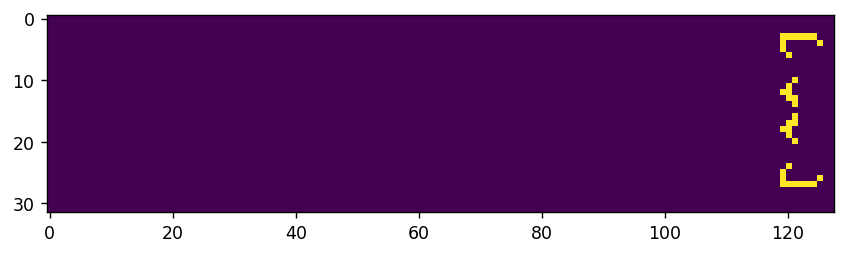

In [115]:
import matplotlib
import matplotlib.pyplot as plt

world = np.array(new_world())

fig = plt.figure(figsize=(8.13, 2.97), dpi=125)
plt.imshow(world)

In [116]:
matplotlib.rc("animation", html="jshtml")
fig = plt.figure(figsize=(8.13, 2.97), dpi=125)

plt.figure(1)
graphic = plt.imshow(world)
plt.close(1)

def update(i):
    global world, graphic
    world = step_numba(world)
    graphic.set_array(world)
    return [graphic]

matplotlib.animation.FuncAnimation(fig, update, frames=250, interval=50, blit=True)